In [99]:
!pip install nltk

In [114]:
import pandas
import torch
import numpy as np
import pickle
import re
import nltk
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from nltk.stem.snowball import SnowballStemmer
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer

In [101]:
stemmer = SnowballStemmer("russian")

In [102]:
def split_line(line):
    return list(filter(lambda x: x != ' ',re.split('(\W)', line)))

In [103]:
DATA_PATH = '../data/'
TRAIN_DATA_PATH = 'train_qa.csv'

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [153]:
train_data = pandas.read_csv(DATA_PATH + TRAIN_DATA_PATH)

In [154]:
train_data = train_data[train_data['question_id'] != 61603]

In [155]:
train_data.columns

Index(['paragraph_id', 'question_id', 'paragraph', 'question', 'answer'], dtype='object')

In [156]:
train_paragraph_unique = train_data[['paragraph_id', 'paragraph']].drop_duplicates()

In [175]:
MAX_DICT = 65000

In [176]:
words_dict = {}
for idp, p in train_paragraph_unique.iterrows():
    text = p['paragraph']
    text_words = split_line(text)
    for word in text_words:
        stemmed_word = stemmer.stem(word.lower())
        if stemmed_word not in words_dict:
            words_dict[stemmed_word] = len(words_dict) + 1

NameError: name 'train_paragraph_unique' is not defined

In [158]:
train_question_unique = train_data['question'].drop_duplicates()

In [159]:
for p in train_question_unique:
    text = p
    text_words = split_line(text)
    for word in text_words:
        stemmed_word = stemmer.stem(word.lower())
        if stemmed_word not in words_dict:
            words_dict[stemmed_word] = len(words_dict) + 1

In [160]:
words_dict['<dlmtr>'] = len(words_dict) + 1

In [8]:
def prepare_text(text):
    text_tokens = [words_dict[stemmer.stem(word.lower())] for word in split_line(text)]
    return text_tokens

In [9]:
def get_id_and_len(text):
    idx = 0
    result = []
    for word in split_line(text):
        word_len = len(word)
        result.append([idx, word_len])
        idx += word_len
    return result

In [10]:
def prepare_answer(text):
    while text[-1] in '.?!':
        text = text[:-1]
    while text[0] in '.?!':
        text = text[1:]
    text = text.lstrip().rstrip()
    return text.lower()

In [105]:
def find_answer_in_text(text, answer):
    text_sent_tokens = nltk.sent_tokenize(text)
    prep_answer = prepare_answer(answer)
    for sent in text_sent_tokens:
        sent = sent.lower()
        idx = sent.find(prep_answer)
        if idx != -1:
            return sent, idx
    return -1

In [165]:
cnt_no_match = 0
no_match_ids = []
train_extracted_sent = []
for idx, r in train_data.iterrows():
    paragraph = r['paragraph']
    answer = r['answer']
    question = r['question']
    find_result = find_answer_in_text(paragraph, answer)
    if find_result == -1:
        cnt_no_match+=1
        no_match_ids.append(idx)
        continue
    sent, answer_idx = find_result
    train_extracted_sent.append([sent, question, answer, answer_idx, len(answer)])
    
cnt_no_match

404

In [166]:
train_extracted_sent[0]

['первые упоминания о строении человеческого тела встречаются в древнем египте.',
 'Где встречаются первые упоминания о строении человеческого тела?',
 'в Древнем Египте',
 60,
 16]

In [167]:
train_extracted_sent[0][0][60:60+16]

'в древнем египте'

In [168]:
find_answer_in_text(train_data['paragraph'][0],train_data['answer'][0])

('первые упоминания о строении человеческого тела встречаются в древнем египте.',
 60)

In [179]:
def prepare_sample_for_model(paragraph, question):
    paragraph = prepare_text(paragraph)
    question = prepare_text(question)
    delemiter = [words_dict['<dlmtr>']]
    return paragraph + delemiter + question

In [180]:
train_extracted_sent[0]

NameError: name 'train_extracted_sent' is not defined

In [171]:
train_data_new = [[prepare_sample_for_model(paragraph, question), idx, idx + answer_len] for \
                  paragraph, question, _, idx, answer_len in train_extracted_sent]

In [172]:
words_dict = defaultdict(lambda x: 0, words_dict)

In [173]:
train_data_new_X = [torch.tensor(x[0]) for x in train_data_new]
train_data_new_y = torch.tensor([[x[1], x[2]] for x in train_data_new])

In [8]:
padding_value = len(words_dict) + 1
train_data_new_X_padded = pad_sequence(train_data_new_X, batch_first=True, padding_value=padding_value)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_data_new_X_padded, train_data_new_y, test_size=0.2, random_state=42)

In [178]:
def backup_data():
    with open("train_data_new_X", 'wb') as f:
        pickle.dump(train_data_new_X, f)
    with open("train_data_new_y", 'wb') as f:
        pickle.dump(train_data_new_y, f)
    with open("words_dict", 'wb') as f:
        pickle.dump(dict(words_dict), f)
        
def backup_data2():
    with open("train", 'wb') as f:
        pickle.dump(train_data_new_X, f)
    with open("test", 'wb') as f:
        pickle.dump(train_data_new_y, f)
    with open("words_dict", 'wb') as f:
        pickle.dump(dict(words_dict), f)

def load_backup_data():
    with open("train_data_new_X", 'rb') as f:
        train_data_new_X = pickle.load(f)
    with open("train_data_new_y", 'rb') as f:
        train_data_new_y = pickle.load(f)
    with open("words_dict", 'rb') as f:
        words_dict = defaultdict(lambda x: 0, pickle.load(f))
    return train_data_new_X, train_data_new_y, words_dict

def load_backup_data_2():
    with open('train', 'rb') as f:
        train_load = pickle.load(f)
    with open('test', 'rb') as f:
        test_load = pickle.load(f)
    with open('words_dict', 'rb') as f:
        words_dict = pickle.load(f)
    return train_load, test_load, words_dict

In [161]:
# backup_data2()
train_load, test_load, words_dict = load_backup_data_2()

In [162]:
words_dict = defaultdict(lambda x: 0, words_dict)

In [177]:
padding_value = MAX_DICT + 1
emb_dim = 64
num_emb = padding_value + 1
num_epochs = 10
batch_size = 128
weight_decay = 0.0001
lr = 0.001
num_layers = 1
hidden_size = 64

In [165]:
class QAModel(nn.Module):
    def __init__(self, num_emb, emb_dim, hidden_size, num_layers, out_size=2):
        super().__init__()
        self.embedding = nn.Embedding(num_emb, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, out_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        z = x
        z = self.embedding(z)
        z, _ = self.lstm(z)
        z = self.fc1(z)
        z = self.dropout(z)
        z = self.relu(z)
        z = self.fc2(z)
        z = torch.transpose(z, 1, 2)
        z = F.log_softmax(z, dim=2)
        return z

In [13]:
X_train[1].shape

torch.Size([508])

In [167]:
def cat_data_and_label(data, label):
    return torch.cat((data, label), dim=1)

In [168]:
def train_model(model, train, test, n_epoch): 
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
    loss_fn = nn.NLLLoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    train_loss = []
    test_loss = []
    for epoch in tqdm.tqdm_notebook(range(n_epoch)):
        train_loss_epoch = []
        test_loss_epoch = []
        for batch in train_loader:
            optim.zero_grad()
            data = batch[:, :-2]
            y = batch[:,-2:]
            data = data.to(device)
            y = y.to(device)
            output = model(data.long())
            y = y.squeeze(1)
            start = y[:,0].reshape(-1)
            end = y[:,1].reshape(-1)
#             print(start.long().shape, end.shape)
#             print(output[:,0].shape, output[:,1].shape)
#             print(output[:,0].long(), start)
#             print(output[:,1].long(), end)
            loss_start = loss_fn(output[:,0], start)
            loss_end = loss_fn(output[:,1], end)        
#             print(torch.max(output),torch.min(output))
#             print(torch.max(start),torch.min(start))
#             print(torch.max(end),torch.min(end))
#             print(output.type())
#             print(start.type())
#             print(end.float().type())
#             print(torch.FloatTensor(end).type())
            loss = (loss_start + loss_end) / 2
#             print(output.dtype, start.dtype)
#             print(loss)
            train_loss_epoch.append(loss.item())
            loss.backward()
            optim.step()
        test_loss_epoch = []
        train_loss.append(np.mean(train_loss_epoch))
        with torch.no_grad():
            for batch in test_loader:
                optim.zero_grad()
                data = batch[:, :-2]
                y = batch[:,-2:]
                data = data.to(device)
                y = y.to(device)
                output = model(data.long())
                y = y.squeeze(1)
                start = y[:,0].reshape(-1)
                end = y[:,1].reshape(-1)
                loss_start = loss_fn(output[:,0], start)
                loss_end = loss_fn(output[:,1], end)        
                loss = (loss_start + loss_end) / 2
                test_loss_epoch.append(loss.item())
            test_loss.append(np.mean(test_loss_epoch))
    return train_loss, test_loss

In [21]:
for x in train_loader:
    print(torch.max(x[:,:-2]))
    break

tensor(59098)


In [169]:
model = QAModel(num_emb, emb_dim, hidden_size, num_layers)
model = model.float()
model = model.to(device)

In [170]:
train_loss, test_loss = train_model(model, train_load, val_load, 10)

In [77]:
len(test_loss), len(train_loss)

(10, 10)

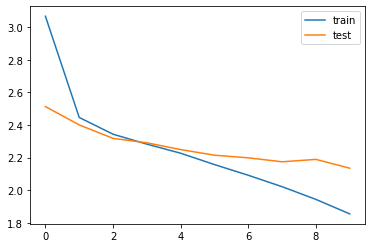

In [171]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

In [172]:
def get_nearest_sent(text, question):
    sent_tokens = nltk.sent_tokenize(text)
    minimum = 10000
    min_token = None
    vect = TfidfVectorizer()
    res = vect.fit_transform(sent_tokens + [text])
    for idx, token in enumerate(sent_tokens):
        dist = cosine(res[idx].todense(), res[q_idx].todense())
        if dist < minimum:
            minimum = dist
            min_token = token
    return min_token

bad q 61603

In [110]:
# bad = 0
# for idx, p in train_data.iterrows():
#     paragraph = p['paragraph'].lower()
#     answer = p['answer']
#     answer = prepare_answer(answer)
#     if answer not in paragraph:
#         print(p['paragraph'], '\n', p['answer'], '\n\n\n\n', p['question'])
#         print(p['paragraph'] == p['answer'])
#         print(p['question_id'])
#         bad += 1
# print(bad)

In [111]:
# def get_index_of_last_token_start(text):
#     split_text = split_line(text)
#     idx = 0
#     for i in range(len(split_text) - 1):
#         idx += len(split_text[i])
#     return idx

In [112]:
# data_answer = []
# for idx, p in train_data.iterrows():
#     paragraph = p['paragraph'].lower()
#     answer = p['answer']
#     answer = prepare_answer(answer)
#     answer_start = paragraph.index(answer)
#     answer_end = answer_start + get_index_of_last_token_start(answer) 
#     data_answer.append([answer_start, answer_end])

In [113]:
# zipped_data = list(zip(data_paragraph, data_question, data_answer))

In [114]:
# data_paragraph_id_and_len = [get_id_and_len(text) for text in train_data['paragraph'].to_numpy()]

In [115]:
# max_len_text = 0
# for idx, p in train_data.iterrows():
#     text = p['paragraph']
#     max_len_text = max(max_len_text, len(text))

In [116]:
# max_len_text

In [117]:
# padding_len = max_len_text * 2

In [118]:
# len(words_dict)